In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
import torch
import cv2



---



---

Person detector


In [ ]:
# Model
person_detector = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5n - yolov5x6, custom

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-6-17 Python-3.7.13 torch-1.11.0+cu113 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 




---



---

Keypoints dectector


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/single-person-pose-estimation')

In [ ]:
from configs import default_config as cfg
from model.hourglass import create_hourglass_model
from dataset_builder import DatasetBuilder
from utilities.model_utils import compile_model_from_checkpoint

In [ ]:
hg = create_hourglass_model(cfg.NUM_KEYPOINTS, 
                                 cfg.HG_NUM_STACKS,
                                 cfg.HG_NUM_CHANNELS,
                                 cfg.IMAGE_SHAPE,
                                 cfg.HM_ACTIVATION)

Created Hourglass model:
    1. 2 stacks.
    2. 7034530 parameters. Call model.get_summary() for more detail.
    


In [ ]:
kps_detector = compile_model_from_checkpoint(hg, '/content/drive/MyDrive/storage/flip fixed/weithedMSE_E30_lr0.001_Adam_sigmoid_2stacks/checkpoints/best_val_loss_weights.ckpt',
                                 optimizer = tf.keras.optimizers.Adam(),
                                 loss = tf.keras.losses.MeanSquaredError())



---

---

Both




In [ ]:
def heatmaps_to_keypoints_v2(heatmaps, conf_threshold = 1e-6):
  ''' Work for one batch
  :param heatmaps: shape(64, 64, number of keypoints)
  :return np.array
  '''
  keypoints = np.zeros(shape=(17, 3), dtype=np.float32)
  for i in range(17):
    heatmap = heatmaps[:,:,i]
    index = np.argmax(heatmap) # return index when flattened
    x = index%64
    y = index//64
    conf = heatmap[y, x]

    # patch
    x1 = max(x-1, 0)
    x2 = min(x+2, 64)
    y1 = max(y-1, 0)
    y2 = min(y+2, 64)
    patch = heatmap[y1:y2, x1:x2]
    patch[1][1] = 0
    patch_index = np.argmax(patch)
    patch_x = patch_index%3
    patch_y = patch_index//3

    delta_x = patch_x/4
    delta_y = patch_y/4


    if conf > conf_threshold:
      keypoints[i, 0] = x + delta_x
      keypoints[i, 1] = y + delta_y
      keypoints[i, 2] = conf
    else:
      keypoints[i, 0] = 0
      keypoints[i, 1] = 0
      keypoints[i, 2] = 0
  return keypoints

In [ ]:
image = cv2.imread('running people.jpg')
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image.dtype

dtype('uint8')

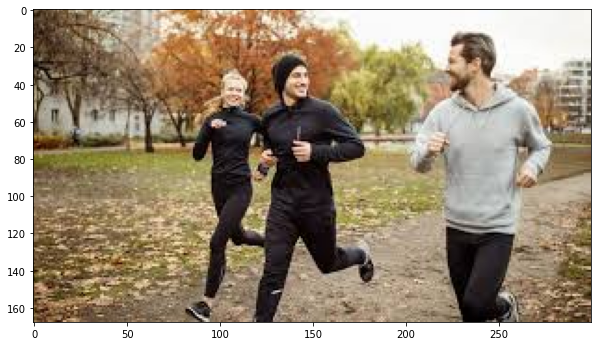

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(image)

In [ ]:
result = person_detector(image)

In [ ]:
df = result.pandas().xyxy[0]
df

,xmin,ymin,xmax,ymax,confidence,class,name
0,202.296188,12.016706,280.609619,164.575623,0.945794,0,person
1,119.217392,23.297968,183.599808,167.414413,0.880312,0,person
2,84.136742,31.886070,128.012726,162.231583,0.852730,0,person
3,205.890076,33.921188,225.265427,62.707241,0.309937,0,person


In [105]:
xmins = df['xmin'].values
ymins = df['ymin'].values
xmaxs = df['xmax'].values
ymaxs = df['ymax'].values
confs = df['confidence'].values
bboxes = []
for xmin, ymin, xmax, ymax, conf in zip(xmins, ymins, xmaxs, ymaxs, confs):
  if conf > 0.75:
    bboxes.append((xmin, ymin, xmax - xmin, ymax - ymin))
print(bboxes)

[(202.2961883544922, 12.016705513000488, 78.31343078613281, 152.55891704559326), (119.21739196777344, 23.2979679107666, 64.38241577148438, 144.11644554138184), (84.1367416381836, 31.886070251464844, 43.87598419189453, 130.34551239013672)]


In [99]:
def transform_bbox_square(bbox, scale = 1):
  '''
  Make bbox into square with the side is the longer side of old bbox
  :param bbox: bbox (x, y, width, height)
  :param scale: scale the bbox
  '''
  x, y, w, h = bbox
  center_x = x + w/2
  center_y = y + h/2

  if w >= h:
    new_w = w
    new_h = w
  else:
    new_w = h
    new_h = h

  new_w *= scale
  new_h *= scale
  new_x = center_x - new_w/2
  new_y = center_y - new_h/2

  return new_x, new_y, new_w, new_h

In [123]:
def draw_bboxes(image, bboxes):
  fig, ax = plt.subplots(figsize = (10, 10))
  for bbox in bboxes:
    new_bbox = transform_bbox_square(bbox, scale = 1.25)
    rect = patches.Rectangle((new_bbox[0], new_bbox[1]), new_bbox[2], new_bbox[3], linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
  ax.imshow(image)
  plt.show()

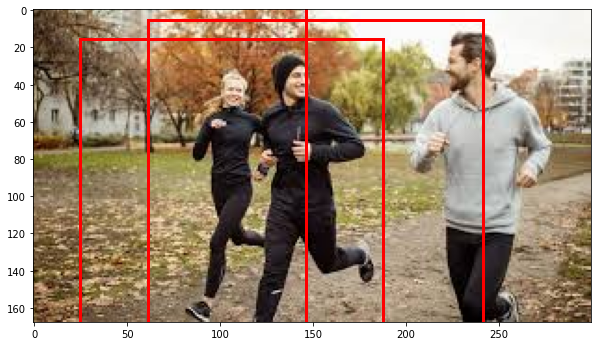

In [124]:
draw_bboxes(image, bboxes)

In [136]:
def crop_to_bboxes(image, bboxes):
  cropped_images = []
  for bbox in bboxes:
    bbox = transform_bbox_square(bbox, scale = 1.25)
    # need to check type
    w, h = int(bbox[2]), int(bbox[3])
    x, y = int(bbox[0]), int(bbox[1]))
    
    xmin = max(0, x)
    ymin = max(0, y)
    xmax = min(xmin+w, image.shape[1])
    ymax = min(ymin+h, image.shape[0])
    cropped = image[ymin:ymax, xmin:xmax,:]


    
  
    

    cropped_images.append(plain) # normalize

  return cropped_images
    

In [137]:
cropped_images =crop_to_bboxes(image, bboxes)

(168, 154, 3)


ValueError: ignored

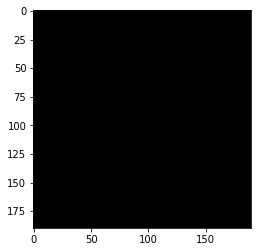

In [111]:
plt.imshow(cropped_images[0])

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(ls[1])

In [ ]:
tf_img = tf.image.resize(ls[0], (256, 256))

In [ ]:
pred = []
for i in ls:
  